Blood Group Detection from Fingerprint using VGG16

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the required libraries

In [2]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
import zipfile
import warnings
warnings.filterwarnings('ignore')

Download and unzip the dataset

In [3]:
!kaggle datasets download -d rajumavinmar/finger-print-based-blood-group-dataset

Dataset URL: https://www.kaggle.com/datasets/rajumavinmar/finger-print-based-blood-group-dataset
License(s): unknown
finger-print-based-blood-group-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
zip_ref = zipfile.ZipFile('/content/finger-print-based-blood-group-dataset.zip')
zip_ref.extractall('/content')
zip_ref.close()

Data preprocessing

In [5]:
file_path = '/content/dataset_blood_group'

In [6]:
data = pd.DataFrame({
    'Filepath': glob.glob(file_path + "/*/*"),
    'Label': [os.path.basename(os.path.dirname(fp)) for fp in glob.glob(file_path + "/*/*")]
})

Splitting the dataset into train and test sets

In [7]:
train, test = train_test_split(data, test_size=0.20, random_state=42, stratify=data["Label"])

Image data augmentation

In [8]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(256, 256),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 4800 validated image filenames belonging to 8 classes.
Found 1200 validated image filenames belonging to 8 classes.


Model architecture

In [9]:
pretrained_model = InceptionV3(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
inputs = pretrained_model.input
x = tf.keras.layers.Flatten()(pretrained_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(8, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 127, 127,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 127, 127,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 127, 127,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 125, 125,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 125, 125,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 125, 125,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 125, 125,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 62, 62,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 62, 62,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 62, 62,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 60, 60,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 60,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 60, 60,    │          0 │ batch_normalizat

 Total params: 40,711,336 (155.30 MB)

 Trainable params: 18,908,552 (72.13 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

Model training

In [11]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=20
)

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 46s 184ms/step - accuracy: 0.4838 - loss: 6.6357 - val_accuracy: 0.7217 - val_loss: 0.9322
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.7970 - loss: 0.7090 - val_accuracy: 0.7367 - val_loss: 0.9867
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step - accuracy: 0.8476 - loss: 0.4634 - val_accuracy: 0.7500 - val_loss: 1.0634
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 107ms/step - accuracy: 0.9177 - loss: 0.2396 - val_accuracy: 0.7867 - val_loss: 0.8207
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 106ms/step - accuracy: 0.9440 - loss: 0.1390 - val_accuracy: 0.8042 - val_loss: 0.7461
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 16s 105ms/step - accuracy: 0.9662 - loss: 0.0860 - val_accuracy: 0.8083 - val_loss: 0.7196
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.9839 - loss: 0.0479 - val_accuracy: 0.7817 - val_loss: 0.9809
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 19s 124ms/step - accuracy: 0.9643 - loss: 0

Saving the model

In [12]:
model.save("InceptionV3.keras")

Model evaluation

In [13]:
name_class = sorted(os.listdir(file_path))
pred = model.predict(valid_gen)
pred_labels = np.argmax(pred, axis=1)
true_labels = valid_gen.classes

print(classification_report(true_labels, pred_labels, target_names=name_class))

38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 223ms/step
              precision    recall  f1-score   support

          A+       0.91      0.86      0.88       113
          A-       0.81      0.70      0.75       202
         AB+       0.89      0.73      0.80       142
         AB-       0.66      0.91      0.77       152
          B+       0.78      0.76      0.77       130
          B-       0.83      0.86      0.84       148
          O+       0.77      0.74      0.76       171
          O-       0.76      0.80      0.78       142

    accuracy                           0.79      1200
   macro avg       0.80      0.79      0.79      1200
weighted avg       0.80      0.79      0.79      1200



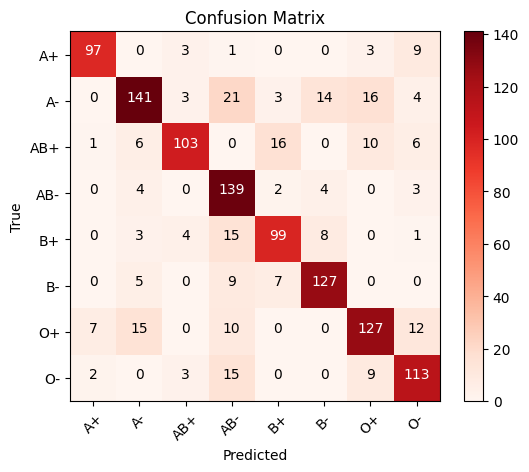

In [14]:
cm = confusion_matrix(true_labels, pred_labels)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(name_class))
plt.xticks(tick_marks, name_class, rotation=45)
plt.yticks(tick_marks, name_class)

for i in range(len(name_class)):
    for j in range(len(name_class)):
        plt.text(j, i, str(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Visualizing accuracy and loss over epochs

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

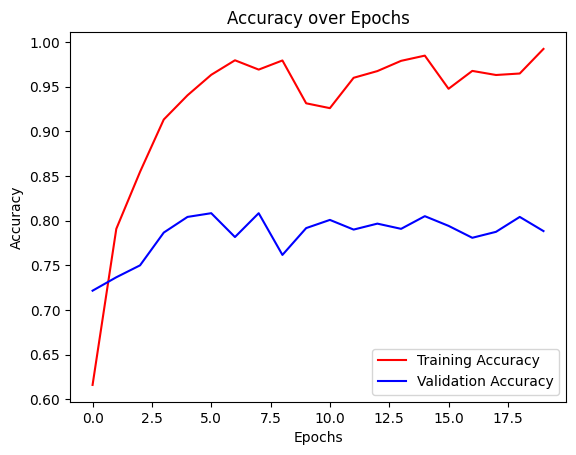

In [16]:
plt.plot(epochs_range, acc, label='Training Accuracy', color='red')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='blue')
plt.legend(loc=0)
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

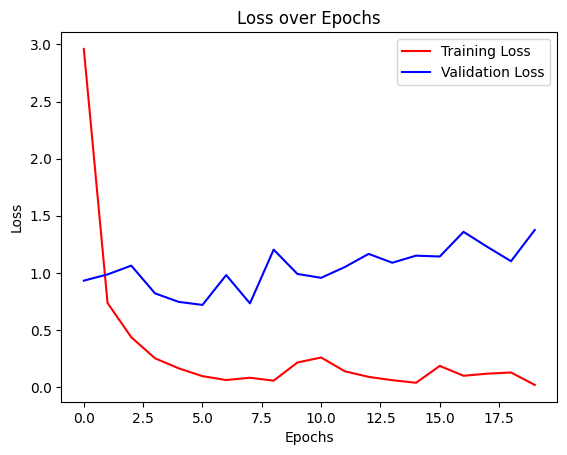

In [17]:
plt.plot(epochs_range, loss, label='Training Loss', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='blue')
plt.legend(loc=0)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Model prediction

In [18]:
class_names = ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']

def predict_blood_group(image_path, model, class_names):
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence_score = np.max(predictions) * 100

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediction: {predicted_class}\nConfidence: {confidence_score:.2f}%", fontsize=14, color='black')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


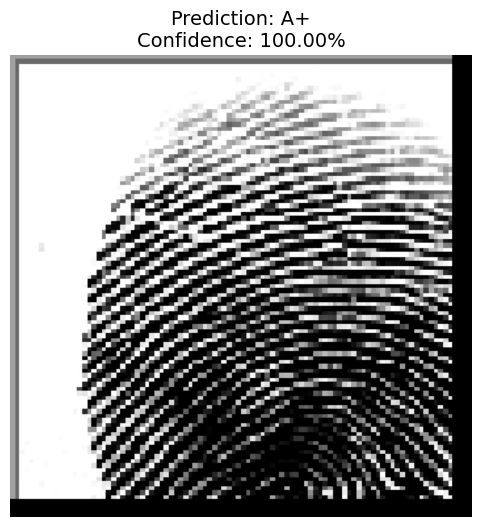

In [19]:
image_path = '/content/dataset_blood_group/A+/cluster_0_1001.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


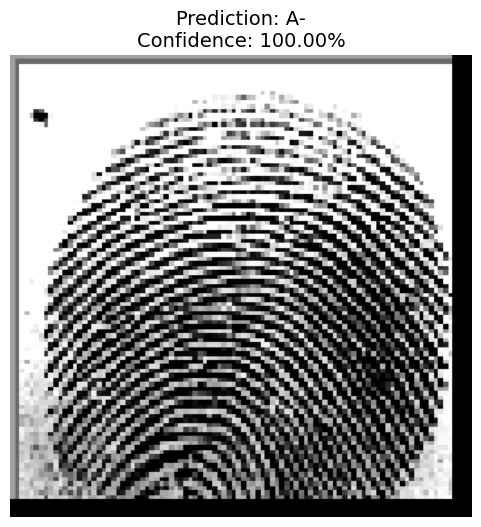

In [20]:
image_path = '/content/dataset_blood_group/A-/cluster_1_1007.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


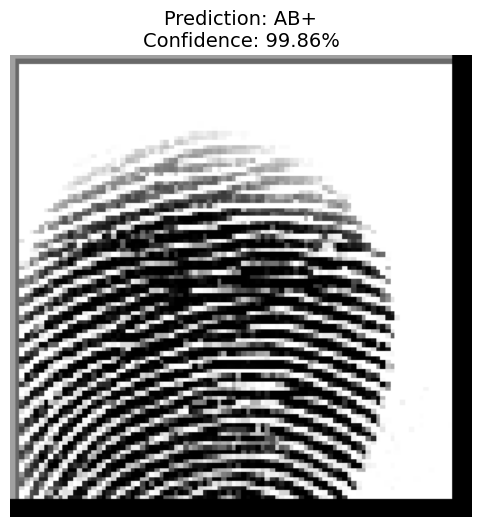

In [21]:
image_path = '/content/dataset_blood_group/AB+/cluster_4_100.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


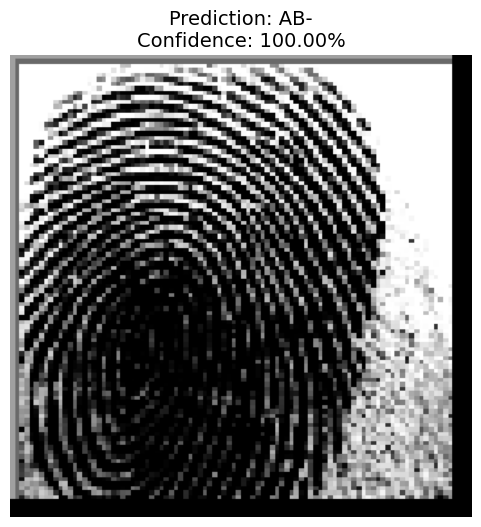

In [22]:
image_path = '/content/dataset_blood_group/AB-/cluster_5_1013.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


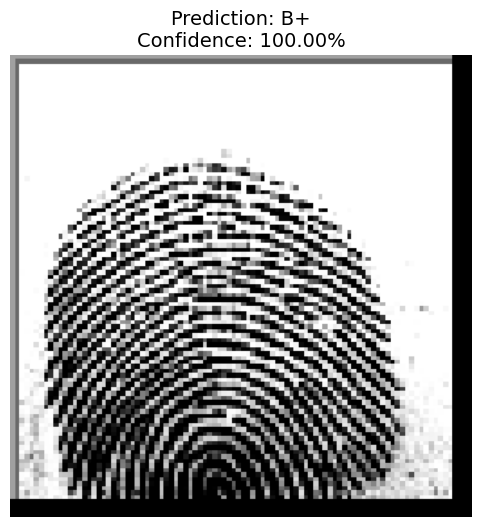

In [23]:
image_path = '/content/dataset_blood_group/B+/cluster_2_1077.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


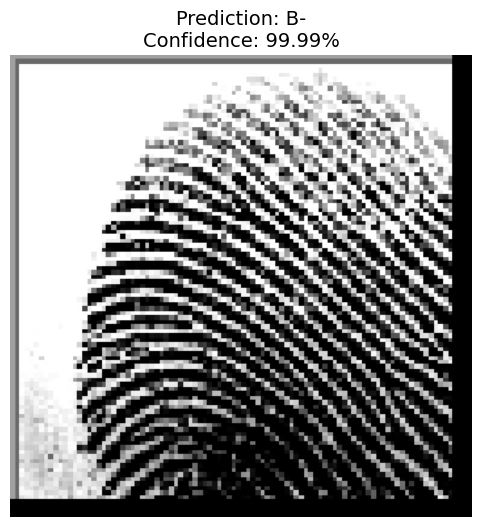

In [24]:
image_path = '/content/dataset_blood_group/B-/cluster_3_1018.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


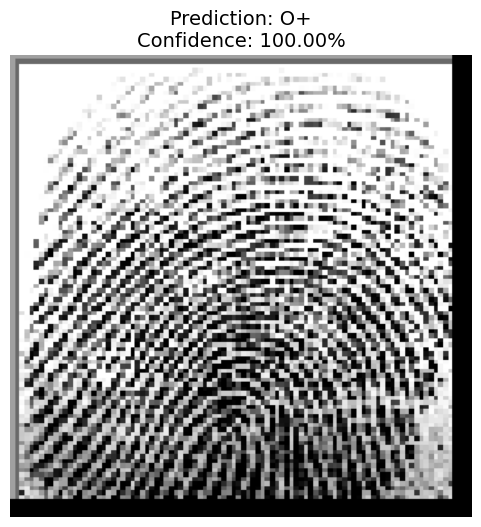

In [25]:
image_path = '/content/dataset_blood_group/O+/cluster_6_1004.BMP'
predict_blood_group(image_path, model, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


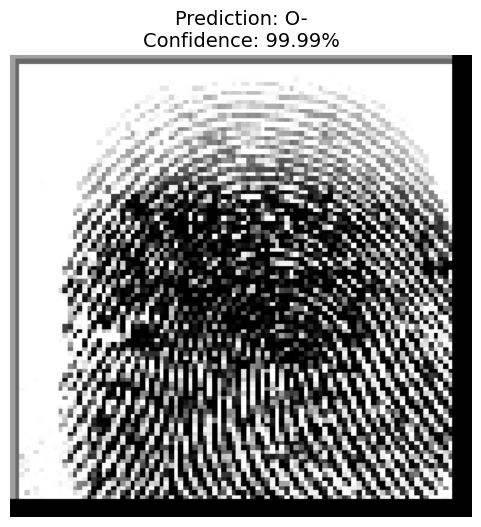

In [26]:
image_path = '/content/dataset_blood_group/O-/cluster_7_1028.BMP'
predict_blood_group(image_path, model, class_names)